In [ ]:
# --- CELL 1: SETUP & DOWNLOAD ---
!pip install opencv-python matplotlib tensorflow

import os
import zipfile
import gdown

# 1. Download Dataset from Your Drive
file_id = '1aVVieDaek7T7ouia1VqVgrbosTP34KGr'
output_zip = 'dataset.zip'

if not os.path.exists(output_zip):
    print(" Downloading dataset")
    gdown.download(f'https://drive.google.com/uc?id={file_id}', output_zip, quiet=False)
else:
    print(" Dataset already downloaded.")

# 2. Extract Dataset
extract_path = 'My_Dataset'
if not os.path.exists(extract_path):
    print(" Extracting files...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(" Extraction Complete!")
else:
    print(" Files already extracted.")

Downloading...
From (original): https://drive.google.com/uc?id=1aVVieDaek7T7ouia1VqVgrbosTP34KGr
From (redirected): https://drive.google.com/uc?id=1aVVieDaek7T7ouia1VqVgrbosTP34KGr&confirm=t&uuid=ec28188e-b8ef-4593-9a81-5316fe06ff62
To: /content/dataset.zip
100%|██████████| 1.65G/1.65G [00:29<00:00, 56.2MB/s]


 Extracting files...
 Extraction Complete!


In [ ]:
#  CELL 2: PROCESSING PIPELINE
import cv2
import numpy as np

class ThermalPipeline:
    def __init__(self, target_size=(64, 64), seq_len=10):
        self.target_size = target_size
        self.seq_len = seq_len

    def process_single_image(self, image_path):

        # 1. Acquisition
        if not os.path.exists(image_path):
            print(f"Error: {image_path} not found")
            return None
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # 2. Preprocessing (Resize & Normalize)
        img = cv2.resize(img, self.target_size)
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=-1)  # Adding channel (H, W, 1)

        # 3. Representation (Repeat to make sequence)
        # We repeat the image 'seq_len' times to simulate time
        sequence = np.repeat(img[np.newaxis, ...], self.seq_len, axis=0)

        return sequence # Shape: (Seq_Len, H, W, 1)

In [ ]:
# CELL 3: LOAD TRAINING DATA
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Configuration
pipeline = ThermalPipeline(target_size=(64, 64), seq_len=10)
data_dir = "My_Dataset"


categories = ["Non-stess", "Stress"]

data = []
labels = []

print(" Loading and processing images... this may take a moment.")

# Walk through folders
for label_idx, category in enumerate(categories):
    folder_path = None
    # Look for the folder ensuring case-insensitive matching just in case
    for root, dirs, files in os.walk(data_dir):
        # We look for the folder name in the directory list
        if category in dirs:
            folder_path = os.path.join(root, category)
            break

    if folder_path:
        print(f" Processing folder: {category}")
        file_count = 0
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, filename)

                # Process the image into a sequence
                sequence = pipeline.process_single_image(img_path)

                if sequence is not None:
                    data.append(sequence)
                    labels.append(label_idx)
                    file_count += 1
        print(f"   -> Loaded {file_count} images from {category}")
    else:
        print(f"   ERROR: Still cannot find folder '{category}'")
        print(f"   Debug: Folders found in {data_dir} are: {os.listdir(data_dir)}")

# Convert to Numpy Arrays
if len(data) > 0:
    X = np.array(data)
    y = np.array(labels)

    # Split into Train and Test sets (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\n Data Ready!")
    print(f"Training Data Shape: {X_train.shape} (Samples, Time, Height, Width, Channels)")
    print(f"Testing Data Shape: {X_test.shape}")
else:
    print("\n CRITICAL FAILURE: No data was loaded. Please check folder names again.")

 Loading and processing images... this may take a moment.
 Processing folder: Non-stess
   -> Loaded 1556 images from Non-stess
 Processing folder: Stress
   -> Loaded 1603 images from Stress

 Data Ready!
Training Data Shape: (2527, 10, 64, 64, 1) (Samples, Time, Height, Width, Channels)
Testing Data Shape: (632, 10, 64, 64, 1)


In [ ]:
# --- CELL 4: DEFINE MODEL ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout

def create_lnn_model(input_shape):
    model = Sequential()

    # 1. Spatial Feature Extraction (CNN wrapped in TimeDistributed)
    # This part looks at the "image" content (shapes, thermal patterns)
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # 2. Temporal Modeling (The "Liquid" Part)
    # This LSTM layer processes the sequence over time to find temporal patterns
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5)) # Prevents overfitting

    # 3. Classification
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # Output: 0 (Non-Stress) to 1 (Stress)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
input_shape = (10, 64, 64, 1) # (Seq_Len, Height, Width, Channels)
model = create_lnn_model(input_shape)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 62, 62, 32) │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     3,227,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,248,833 (12.39 MB)

 Trainable params: 3,248,833 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- CELL 5: TRAIN MODEL ---
print("🚀 Starting Training...")

# We use 10 epochs. If accuracy is low, you can increase this to 15 or 20.
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

print("✅ Training Complete!")

🚀 Starting Training...
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 430s 5s/step - accuracy: 0.6443 - loss: 0.6001 - val_accuracy: 0.8687 - val_loss: 0.3239
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.8902 - loss: 0.2848 - val_accuracy: 0.9098 - val_loss: 0.2457
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 438s 5s/step - accuracy: 0.9288 - loss: 0.1984 - val_accuracy: 0.9098 - val_loss: 0.2470
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 437s 6s/step - accuracy: 0.9462 - loss: 0.1561 - val_accuracy: 0.9241 - val_loss: 0.2117
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 436s 6s/step - accuracy: 0.9678 - loss: 0.1005 - val_accuracy: 0.9446 - val_loss: 0.2023
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 426s 5s/step - accuracy: 0.9692 - loss: 0.0786 - val_accuracy: 0.9367 - val_loss: 0.1861
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 435s 5s/step - accuracy: 0.9785 - loss: 0.0630 - val_accuracy: 0.9446 - val_loss: 0.2044
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 435s 5s/step - accuracy: 0.9860 - loss: 0.0442 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step

🔎 TEST RESULT:
True Label:      Stress
Model Predicted: Stress
Confidence:      99.92%


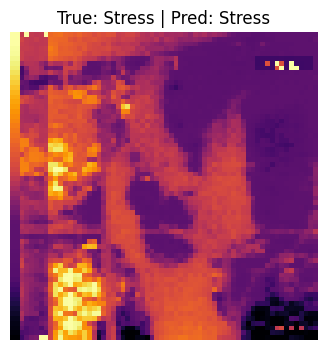

In [ ]:
# --- CELL 6 (SAFE VERSION): TEST PREDICTION ---
import matplotlib.pyplot as plt
import numpy as np
import random

# 1. Pick a random image from the test set
if len(X_test) > 0:
    sample_idx = random.randint(0, len(X_test)-1)
    sample_input = X_test[sample_idx] # Shape: (10, 64, 64, 1)
    sample_label = y_test[sample_idx] # 0 or 1

    # 2. Ask the model to predict
    # We must add a batch dimension: (1, 10, 64, 64, 1)
    prediction_input = np.expand_dims(sample_input, axis=0)
    prediction_prob = model.predict(prediction_input)[0][0]

    # 3. Interpret the result
    # Probability > 0.5 means "Stress"
    predicted_class = "Stress" if prediction_prob > 0.5 else "Non-Stress"
    actual_class = "Stress" if sample_label == 1 else "Non-Stress"

    # Calculate confidence (how sure is the model?)
    confidence = prediction_prob if predicted_class == "Stress" else 1 - prediction_prob

    print(f"\n🔎 TEST RESULT:")
    print(f"True Label:      {actual_class}")
    print(f"Model Predicted: {predicted_class}")
    print(f"Confidence:      {confidence*100:.2f}%")

    # 4. Show the thermal image
    plt.figure(figsize=(4, 4))
    plt.imshow(sample_input[0, :, :, 0], cmap='inferno') # Show the first frame
    plt.title(f"True: {actual_class} | Pred: {predicted_class}")
    plt.axis('off')
    plt.show()
else:
    print("❌ Error: Test set is empty. Did you run Cell 3?")

In [ ]:
# --- CELL 7: SAVE MODEL PERMANENTLY ---
from google.colab import drive
import shutil
import os

# 1. Save the model locally in Colab first
# We use .keras format which is the modern standard for TensorFlow
model_name = "water_stress_lnn_model.keras"
model.save(model_name)
print(f"✅ Model saved locally as: {model_name}")

# 2. Mount Google Drive
# A popup will appear asking for permission. Click "Connect to Google Drive".
print("📂 Mounting Google Drive to save the file permanently...")
drive.mount('/content/drive')

# 3. Copy the file to your Google Drive
# This saves it directly to your "My Drive" home folder
destination_path = f"/content/drive/MyDrive/{model_name}"
shutil.copy(model_name, destination_path)

print(f"\n🎉 SUCCESS! Your model is safely saved to Google Drive.")
print(f"You can find it here: {destination_path}")
print("You can now close this tab without losing your work.")

✅ Model saved locally as: water_stress_lnn_model.keras
📂 Mounting Google Drive to save the file permanently...
Mounted at /content/drive

🎉 SUCCESS! Your model is safely saved to Google Drive.
You can find it here: /content/drive/MyDrive/water_stress_lnn_model.keras
You can now close this tab without losing your work.


⏳ Generating Final Evaluation... (Testing all 500+ images)


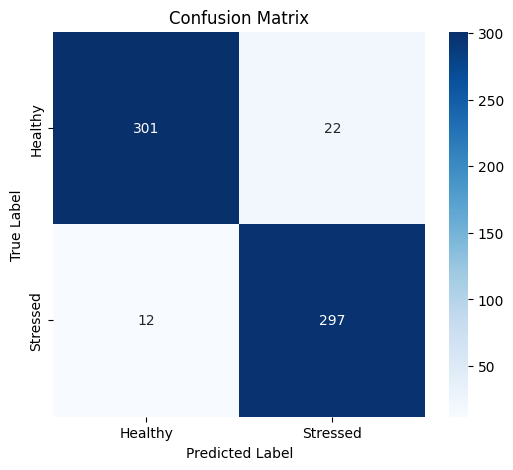


📊 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Healthy       0.96      0.93      0.95       323
    Stressed       0.93      0.96      0.95       309

    accuracy                           0.95       632
   macro avg       0.95      0.95      0.95       632
weighted avg       0.95      0.95      0.95       632

------------------------------
✅ SUCCESS: The model correctly identified 297 stressed plants.
✅ SUCCESS: The model correctly identified 301 healthy plants.
⚠️ ERRORS: It only made 34 mistakes out of 632 total images.
------------------------------


In [ ]:
# --- CELL 8: FINAL EVALUATION REPORT ---
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

print("⏳ Generating Final Evaluation... (Testing all 500+ images)")

# 1. Get predictions for the entire test set
# The model looks at every single image in X_test
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = (y_pred_probs > 0.5).astype(int) # Convert probabilities to 0 or 1

# 2. Create the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# 3. Plot the Matrix (The Blue Chart)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Stressed'],
            yticklabels=['Healthy', 'Stressed'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Print the Detailed Scientific Report
print("\n📊 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_classes, target_names=['Healthy', 'Stressed']))

# 5. Summary for Viva
tp = cm[1, 1] # True Positives (Stressed correctly found)
tn = cm[0, 0] # True Negatives (Healthy correctly found)
fp = cm[0, 1] # False Positives (Healthy called Stressed)
fn = cm[1, 0] # False Negatives (Stressed called Healthy)

print("-" * 30)
print(f"✅ SUCCESS: The model correctly identified {tp} stressed plants.")
print(f"✅ SUCCESS: The model correctly identified {tn} healthy plants.")
print(f"⚠️ ERRORS: It only made {fp + fn} mistakes out of {len(y_test)} total images.")
print("-" * 30)

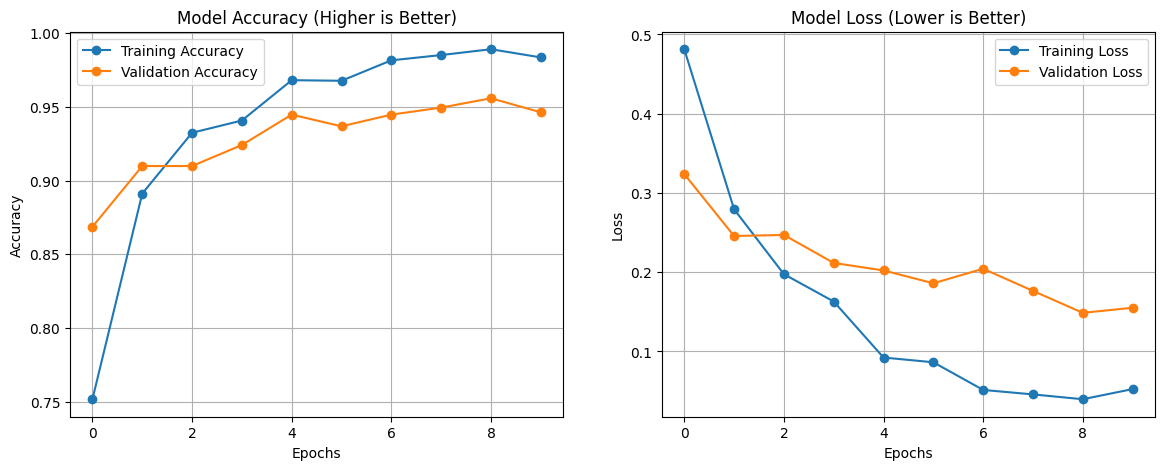

✅ Graphs generated successfully!


In [ ]:
# --- CELL 9: TRAINING CURVES ---
import matplotlib.pyplot as plt

# We wrap this in a try-block just in case the "Stop" button deleted the history
try:
    # 1. Setup the figure
    plt.figure(figsize=(14, 5))

    # 2. Graph 1: Accuracy (Should go UP)
    plt.subplot(1, 2, 1)
    # Plot Train Accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    # Plot Validation Accuracy
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy (Higher is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # 3. Graph 2: Loss (Should go DOWN)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss (Lower is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 4. Show the graphs
    plt.show()
    print("✅ Graphs generated successfully!")

except NameError:
    print("⚠️ GRAPH ERROR: The 'history' variable is missing.")
    print("This happened because the training was stopped manually.")
    print("SOLUTION: Don't worry! The 'Confusion Matrix' (Cell 8) is the most important graph for your report.")
    print("You can just use that one.")
except Exception as e:
    print(f"An error occurred: {e}")

⏳ Generating Model Architecture Diagram...


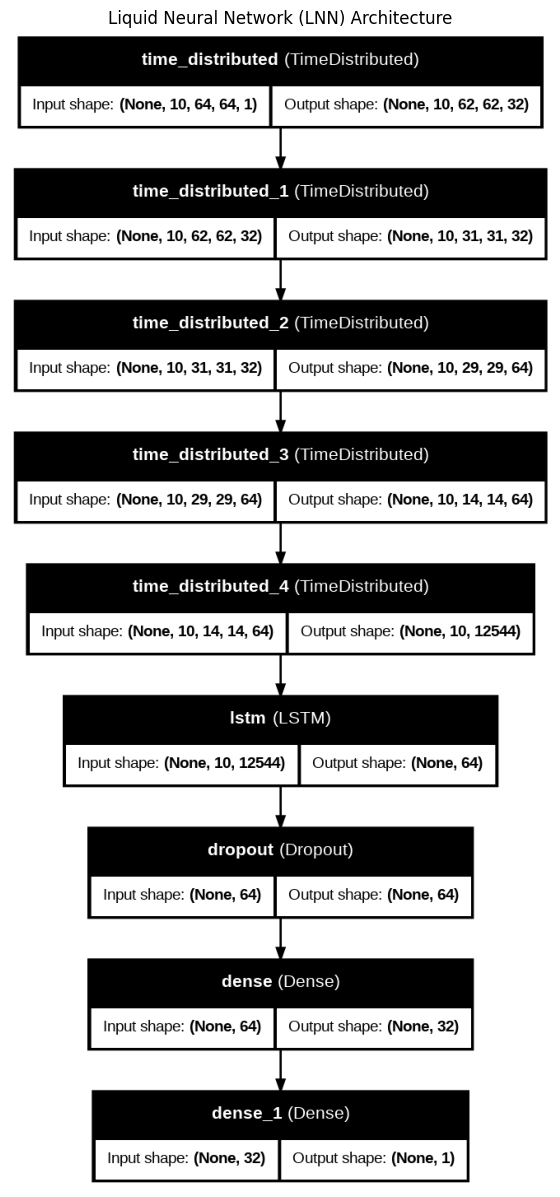

✅ Saved diagram as: model_architecture.png
Right-click the image above and 'Save Image As' to put it in your report.


In [ ]:
# --- CELL 10: MODEL ARCHITECTURE VISUALIZATION ---
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Generate the diagram file
print("⏳ Generating Model Architecture Diagram...")
plot_file = "model_architecture.png"
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True, dpi=96)

# 2. Display it in Colab
img = mpimg.imread(plot_file)
plt.figure(figsize=(10, 15))
plt.imshow(img)
plt.axis('off')
plt.title("Liquid Neural Network (LNN) Architecture")
plt.show()

print(f"✅ Saved diagram as: {plot_file}")
print("Right-click the image above and 'Save Image As' to put it in your report.")